In [1]:
%matplotlib inline
import sys
sys.path.append("../..")
from IPython.display import display

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from magine.networks.utils import subtract_network_from_network
from magine.networks.subgraphs import Subgraph
from magine.networks.visualization.notebooks.view import display_graph
from magine.enrichment.enrichr import Enrichr
from exp_data import exp_data
from collections import Counter
e = Enrichr()

In [3]:
ecn = nx.read_gml('canonical_kegg_hmdb_biogrid_reactome_signor.gml')
ddn = nx.read_gpickle('Data/cisplatin_network_w_attributes.p')

In [4]:
subtracted_net = subtract_network_from_network(ddn, ecn)

nx.write_gml(subtracted_net, 'subtracted_network.gml')

# make copy to edit
subtracted_net_copy = subtracted_net.copy()

# conver to undirected, sort by connectivity
tmp_g = subtracted_net.to_undirected()
sorted_graphs = sorted(nx.connected_component_subgraphs(tmp_g), key=len, reverse=True)

In [5]:
node_list = []
group_to_nodes = dict()
counter = 0

for i in sorted_graphs:
    nodes = set(i.nodes)
    n_nodes = len(nodes)
    node_list.append(n_nodes)
    if n_nodes <= 2:
        subtracted_net_copy.remove_nodes_from(nodes)
        continue
    
    sig_hit = 0
    measured_hit = 0
    
    for node, data in i.nodes(data=True):
        if data['seed'] == 'red':
            sig_hit += 1
        if data['measured'] == 'red':
            measured_hit += 1
    
    fraction_sig = float(sig_hit)/float(n_nodes)*100.
    fraction_measured = float(measured_hit)/float(n_nodes)*100.
    
    if fraction_sig <= 50.:
        subtracted_net_copy.remove_nodes_from(nodes)
    else:
        name = 'group{0:05d}'.format(counter)
        print(name)
        for i in nodes:
            subtracted_net_copy.node[i]['group'] = name
        group_to_nodes[name] = nodes
        counter += 1
        
nx.write_gml(subtracted_net_copy, 'subtracted_network_filtered.gml')  

display(Counter(node_list))

group00000
group00001
group00002
group00003
group00004
group00005
group00006
group00007
group00008
group00009
group00010
group00011
group00012
group00013
group00014
group00015
group00016
group00017
group00018
group00019
group00020
group00021
group00022
group00023
group00024
group00025
group00026
group00027
group00028


Counter({1: 4086,
         2: 47,
         3: 23,
         4: 8,
         5: 5,
         6: 4,
         7: 1,
         8: 1,
         10: 1,
         12: 1,
         365: 1,
         6481: 1})

Number of rows went from 8 to 7


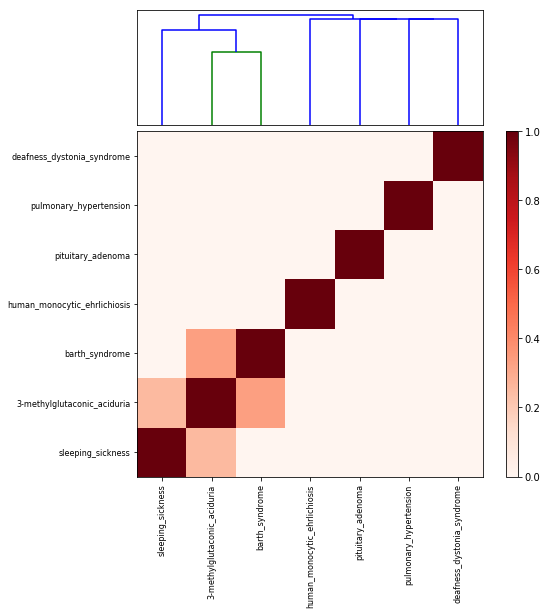

In [6]:
df = e.run(group_to_nodes['group00001'], 'Jensen_DISEASES')
df['sample_id'] = 1
df.filter_multi(p_value=0.05, inplace=True)
df.head(10)
df.remove_redundant(inplace=True)
df.dist_matrix(level='sample');

In [7]:
display(df.head(10))

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,sample_id
0,3-methylglutaconic_aciduria,1,5.360764e-07,-2.725174,39.348756,0.000006,"DNAJC19,PMPCB,TIMM50",3,Jensen_DISEASES,1
1,sleeping_sickness,2,1.942113e-04,-2.505006,21.409196,0.001165,"TIMM17A,TIMM50",2,Jensen_DISEASES,1
2,barth_syndrome,3,1.253092e-02,-2.659908,11.649218,0.021482,DNAJC19,1,Jensen_DISEASES,1
3,pulmonary_hypertension,4,7.774306e-03,-2.320183,11.268969,0.018658,PMPCA,1,Jensen_DISEASES,1
4,deafness_dystonia_syndrome,5,1.074964e-02,-2.370633,10.745800,0.021482,TIMM23,1,Jensen_DISEASES,1
5,pituitary_adenoma,6,1.844728e-02,-2.634570,10.519410,0.027671,PAM16,1,Jensen_DISEASES,1
10,human_monocytic_ehrlichiosis,11,2.996701e-03,-0.812717,4.722081,0.010785,GRPEL1,1,Jensen_DISEASES,1


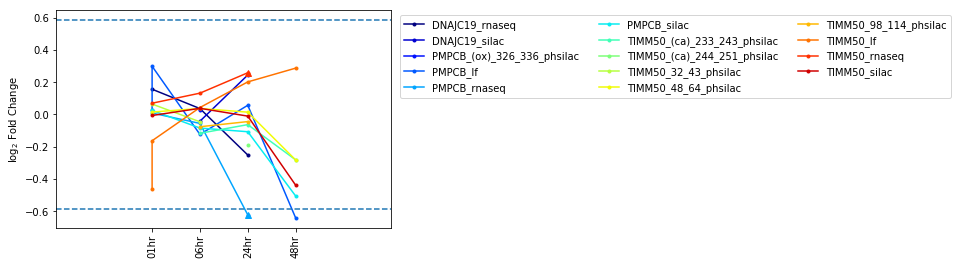

In [10]:
exp_data.species.plot_species(df.term_to_genes('3-methylglutaconic_aciduria'),
                      'pmbca', image_format='png', plot_type='matplotlib');

In [ ]:
df2 = e.run(group_to_nodes['group1'], 'Reactome_2016')
df2['sample_id']= 1
df2.filter_multi(p_value=0.05, inplace=True)
df2.remove_redundant(inplace=True)
display(df2.head(10))
if df2.shape[0] > 1:
    df2.dist_matrix(level='sample');


In [13]:
ns = Subgraph(network=ddn)

In [ ]:
sub = ns.paths_between_list(
    df.term_to_genes('purine_nucleoside_phosphorylase_deficiency'), 
    max_length=2
)

display_graph(sub)

In [ ]:
sub = ns.paths_between_list(df2.term_to_genes('3-methylglutaconic_aciduria'))
sub = ns.expand_neighbors(sub, nodes=list(sub.nodes), upstream=True, downstream=True, max_dist=1)
# sub = ns.expand_neighbors(sub, nodes=list(sub.nodes), upstream=True, downstream=True, max_dist=3)
display_graph(sub)

In [ ]:
sub = ns.neighbors('TIMM23')
display_graph(sub)
                   

# Group 1
MPTP complex is known to get activated under high ROS conditions and Ca2+ overload,13 leading to increase fluid uptake due to MPT; thus resulting in potential loss, organellar swelling and induction of cell death

https://www.nature.com/articles/cddis201472

In [ ]:
def run(group, db='Reactome_2016'):
    df2 = e.run(group_to_nodes[group], db)
    if df2.shape[0] > 1:
        df2['sample_id']= 1
        df2.filter_multi(p_value=0.05, inplace=True)
        df2.remove_redundant(inplace=True)
    if df2.shape[0] > 1:
        df2.dist_matrix(level='sample');
    display(df2)
run('group00001')

In [ ]:
run('group00002')

In [ ]:
run('group00004')

In [ ]:
all_genes = exp_data.ph_silac.sig.label_list
nodes = set(ddn.nodes)
missing = all_genes.difference(nodes)
print(len(missing))

In [ ]:
print(sorted(missing))

In [ ]:
# remove orfs and non-read transcripts
print(len(missing))
missing = set(i for i in missing if not i.startswith('AC') and not '.' in i)
print(len(missing))
missing = set(i for i in missing if not i.startswith('RP') and not '.' in i)
print(len(missing))
missing = set(i for i in missing if not 'orf' in i)
print(len(missing))
mirs = set(i for i in missing if i.startswith('MIR'))
phospho = set(i.split('_')[0] for i in missing if '(ph' in i)
print(phospho)
missing.difference_update(mirs)
print(len(missing))
# print(phospho)
print(len(phospho))
# print('\n'.join(mirs))

In [ ]:
df = e.run(phospho, 'KEA_2015')
display(df)

In [ ]:
df['sample_id'] = 1
df.filter_multi(p_value=0.05, combined_score=1, inplace=True)
df.remove_redundant(inplace=True)
display(df)
df.dist_matrix();

In [ ]:
df

Number of rows went from 28 to 28


,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,sample_id
0,CDK2,1,3.001021e-108,-2.105552,521.293000,8.492891e-106,"AAK1,ABLIM1,ACLY,ADD1,ADD2,ADD3,AFF1,AHNAK,AKA...",244,KEA_2015,1
1,CDK1,2,1.096827e-66,-2.087561,317.054974,1.552011e-64,"AAK1,ABLIM1,ACLY,ADD1,AHNAK,ANLN,ATN1,BAD,BAG3...",184,KEA_2015,1
2,GSK3B,3,1.505536e-61,-2.052101,287.393693,1.420222e-59,"AAK1,ACLY,ADD1,ADD2,ADD3,AFF1,AHNAK,AKAP1,ANLN...",184,KEA_2015,1
3,MAPK14,4,3.391714e-52,-1.947660,230.823170,2.399637e-50,"ACLY,AGPS,AHNAK,ANLN,ARHGAP12,ARRB1,ATF2,ATN1,...",146,KEA_2015,1
4,RPS6KA3,5,1.007597e-42,-1.930607,186.691614,4.752498e-41,"ABCA1,ABLIM1,ACLY,ADD1,ADD3,AHNAK,ARFGEF2,ARHG...",121,KEA_2015,1
5,MAPK1,6,6.843438e-43,-1.869354,181.491549,3.873386e-41,"AAK1,ABI1,AHNAK,AHNAK2,AKAP12,ARHGEF17,ARHGEF2...",120,KEA_2015,1
6,CHEK1,7,1.896740e-30,-1.540587,105.433771,7.668251e-29,"ADD1,ADD2,ADD3,ARHGEF2,BAZ1A,CAAP1,CAMSAP2,CCD...",64,KEA_2015,1
7,MAPK8,8,9.781784e-28,-1.624391,101.023929,3.460306e-26,"AAK1,ADD2,AHNAK,AKAP1,ARID1A,ATF2,ATN1,BAD,BCL...",80,KEA_2015,1
8,MAPK3,9,1.136979e-23,-1.602598,84.666962,3.575167e-22,"ABI1,ABLIM1,ARHGEF2,ARRB1,ATF2,BCL2L11,BRAF,CA...",70,KEA_2015,1
9,AKT1,10,1.495471e-22,-1.552946,78.042398,4.232182e-21,"ACIN1,ACLY,BAD,BCL2L11,BRAF,CARHSP1,CBY1,CCDC8...",70,KEA_2015,1


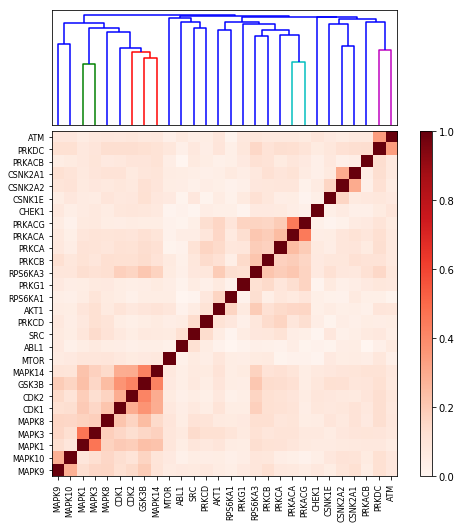

In [11]:
phospho = set(i.split('_')[0] for i in exp_data.ph_silac.sig.label_list if '(ph' in i)
df = e.run(phospho, 'KEA_2015')
df['term_name'] = df['term_name'].str.upper()
df['sample_id'] = 1
df.filter_multi(p_value=0.05, combined_score=1, inplace=True)
df.remove_redundant(inplace=True)
display(df)
df.dist_matrix();

# Auditory system clue
GSK3B is highly active. This paper shows that its inhibition could save auditory cells. 
https://www.ncbi.nlm.nih.gov/pubmed/19666099

In [14]:
display_graph(ns.neighbors('GSK3B', upstream=False, downstream=True, include_only=exp_data.species.sig.id_list))

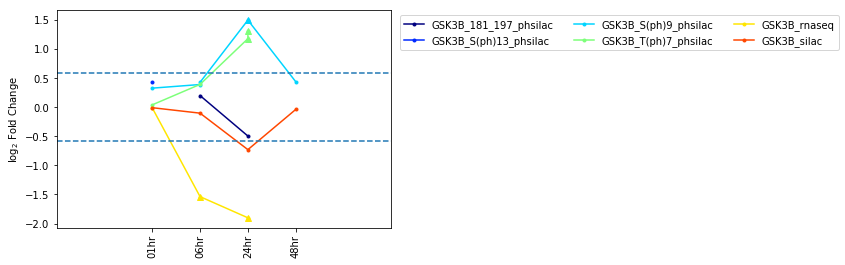

In [19]:
exp_data.genes.plot_species(['GSK3B'], 'test', plot_type='matplotlib');